https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy import stats as st

In [39]:
columns = ["Gender","Age","Height","Weight","family_history_with_overweight","FAVC","FCVC","NCP","CAEC","SMOKE","CH2O","SCC","FAF","TUE","CALC","MTRANS","NObeyesdad"]

df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv", names=columns)

df = df.drop(0)
df["Age"] = df["Age"].astype(float).round().astype(int)
df["Weight"] = df["Weight"].astype(float).round().astype(int)

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1,Female,21,1.62,64,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
2,Female,21,1.52,56,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
3,Male,23,1.8,77,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
4,Male,27,1.8,87,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
5,Male,22,1.78,90,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


In [40]:
# male = 1; female = 0
df["Gender"] = df["Gender"].apply(lambda x: 0 if x == "Female" else 1)

# yes = 1; no = 0
df["family_history_with_overweight"] = df["family_history_with_overweight"].apply(lambda x: 1 if x == "yes" else 0)

# yes = 1; no = 0
df["FAVC"] = df["FAVC"].apply(lambda x: 1 if x == "yes" else 0)

# yes = 1; no = 0
df["SMOKE"] = df["SMOKE"].apply(lambda x: 1 if x == "yes" else 0)

# yes = 1; no = 0
df["SCC"] = df["SCC"].apply(lambda x: 1 if x == "yes" else 0)

# walking = 1; vehicle = 0
df["MTRANS"] = df["MTRANS"].apply(lambda x: 1 if x == "Walking" else 0)

label_mapping = {
    "Normal_Weight": 0,
    "Insufficient_Weight": 0,
    "Overweight_Level_I": 0.5,
    "Overweight_Level_II": 0.5,
    "Obesity_Type_I": 1,
    "Obesity_Type_II": 2,
    "Obesity_Type_III": 3
}

# Apply the mapping using the lambda function
df["NObeyesdad"] = df["NObeyesdad"].apply(lambda x: label_mapping.get(x, x))

label_mapping = {
    "no": 0,
    "Sometimes": 1,
    "Frequently": 2,
    "Always": 3,
}

# Apply the mapping using the lambda function
df["CALC"] = df["CALC"].apply(lambda x: label_mapping.get(x, x))
df["CAEC"] = df["CAEC"].apply(lambda x: label_mapping.get(x, x))

df.head(20)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1,0,21,1.62,64,1,0,2,3,1,0,2,0,0,1,0,0,0.0
2,0,21,1.52,56,1,0,3,3,1,1,3,1,3,0,1,0,0.0
3,1,23,1.8,77,1,0,2,3,1,0,2,0,2,1,2,0,0.0
4,1,27,1.8,87,0,0,3,3,1,0,2,0,2,0,2,1,0.5
5,1,22,1.78,90,0,0,2,1,1,0,2,0,0,0,1,0,0.5
6,1,29,1.62,53,0,1,2,3,1,0,2,0,0,0,1,0,0.0
7,0,23,1.5,55,1,1,3,3,1,0,2,0,1,0,1,0,0.0
8,1,22,1.64,53,0,0,2,3,1,0,2,0,3,0,1,0,0.0
9,1,24,1.78,64,1,1,3,3,1,0,2,0,1,1,2,0,0.0
10,1,22,1.72,68,1,1,2,3,1,0,2,0,1,1,0,0,0.0


In [41]:
df.shape

(2111, 17)

In [42]:
missing = []
# loop through all rows in the dataframe with df.iterrows()
for i, row in df.iterrows():
    try:
        # check if each value in the row can be turned into a float
        [float(val) for val in list(row)]
    except:
        # if cannot be converted to a float, this row has invalid data.
        missing.append(i)
missing

[]

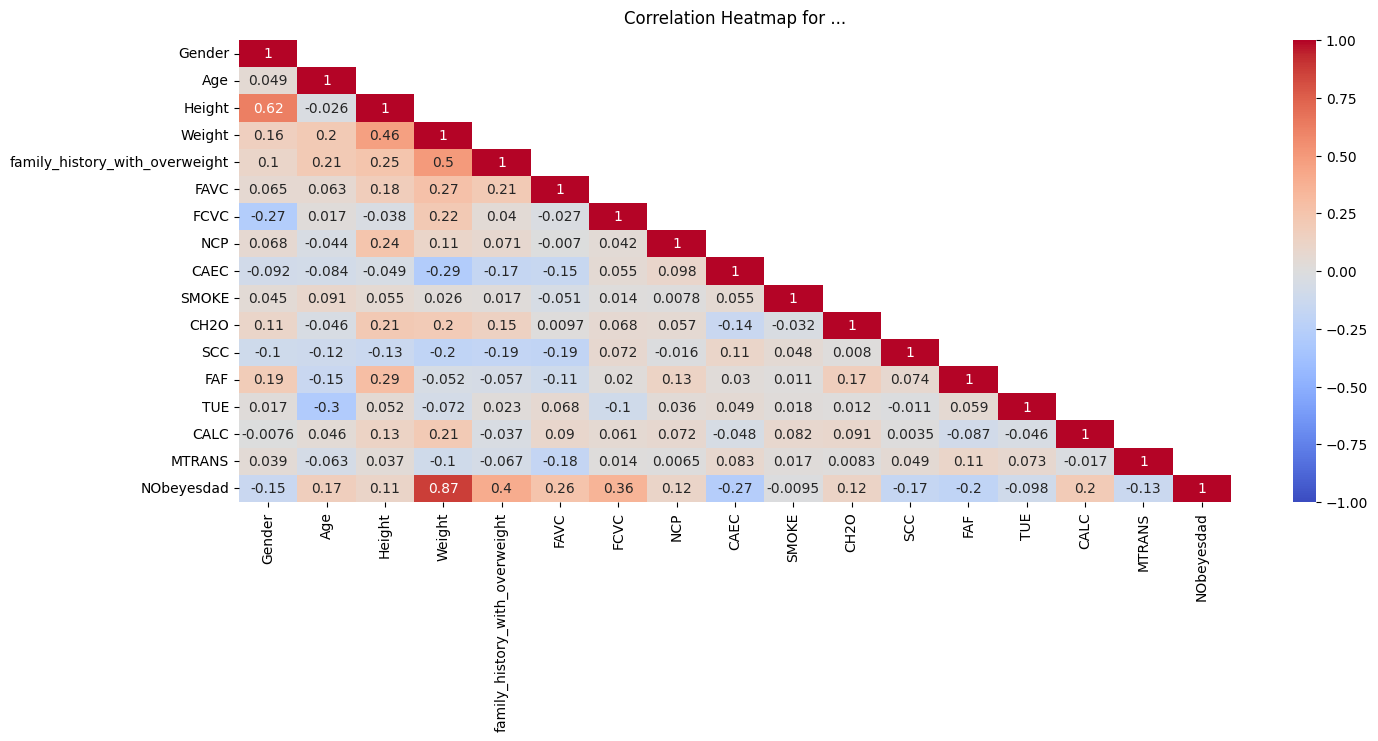

In [43]:
plt.figure(figsize=(16, 6))

corr = df.corr()

mask=np.triu(corr)
np.fill_diagonal(mask, False)

heatmap = sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, mask=mask)
heatmap.set_title("Correlation Heatmap for ...", fontdict={"fontsize":12}, pad=12)

plt.show()

In [44]:
allAge = df["Age"].sort_values().unique()
allAge

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 51, 52, 55, 56, 61])

In [45]:
allAge.size

40

In [46]:
labels = ["Ages 14 to 23", "Ages 24 to 33", "Ages 34 to 43", "Ages 44 to 61"]

bins = [14, 29, 33, 43, 61]
ages = df.groupby(pd.cut(df["Age"], bins))
age_dfs = []

for i, age in enumerate(ages.groups.keys()):
    curr = ages.get_group(age)
    age_dfs.append(curr)
    print(f"Length of bin {i + 1} ({labels[i]}): {len(curr)}")

Length of bin 1 (Ages 14 to 23): 1724
Length of bin 2 (Ages 24 to 33): 178
Length of bin 3 (Ages 34 to 43): 185
Length of bin 4 (Ages 44 to 61): 23


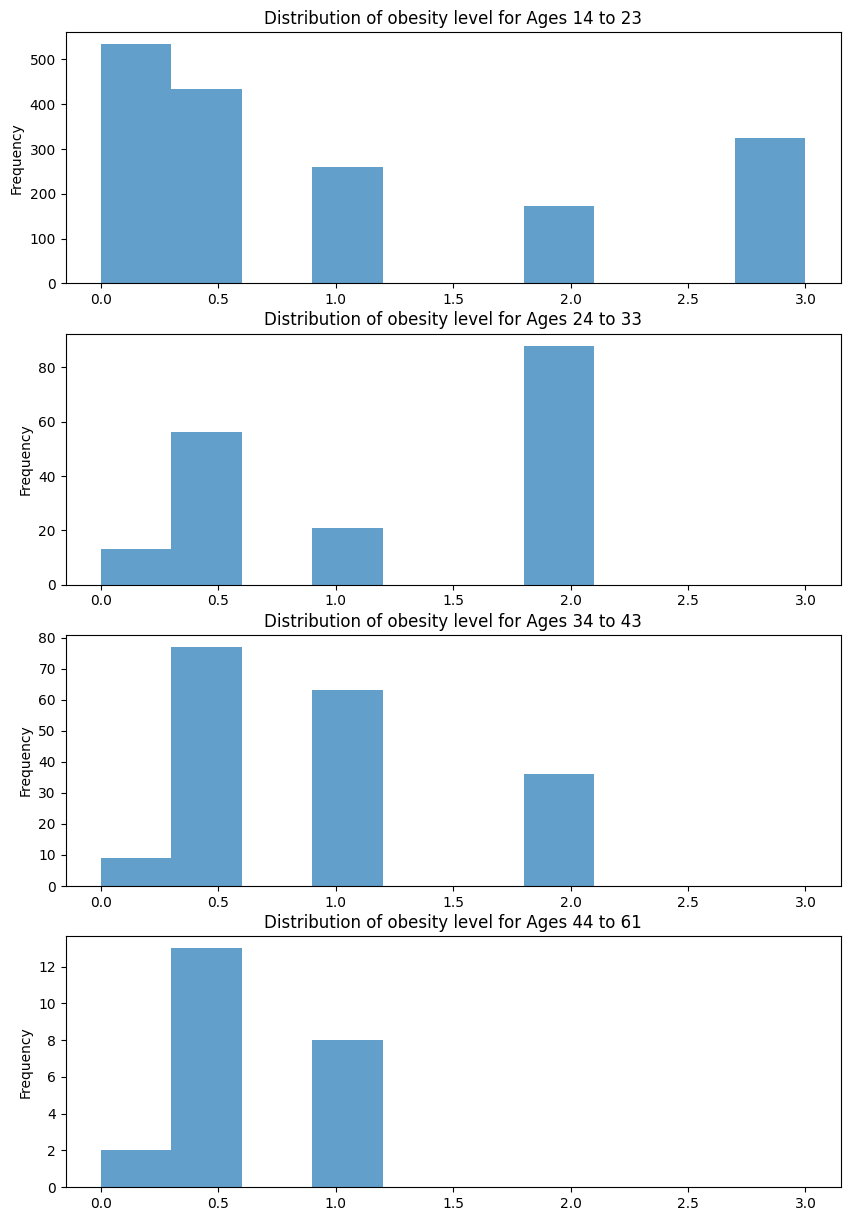

In [47]:
min = np.min(df["NObeyesdad"])
max = np.max(df["NObeyesdad"])

fig, axs = plt.subplots(4, figsize=(10, 15))

for i in range(4):
    axs[i].hist(age_dfs[i]["NObeyesdad"], range=(min, max), alpha=0.7, label=labels[i])
    axs[i].set(title=f"Distribution of obesity level for {labels[i]}", ylabel="Frequency")

plt.show()

In [48]:
allWeight = df["Weight"].sort_values().unique()
allWeight

array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 147, 149, 150, 151, 152, 153, 154, 155, 156, 161, 165,
       173])

In [49]:
allWeight.size

118

In [50]:
labels = ["Weights 39 to 69", "Weights 70 to 89", "Weights 90 to 119", "Weights 120 to 139", "Weights 140 to 173"]

bins = [39, 69, 89, 119, 139, 173]
weights = df.groupby(pd.cut(df["Weight"], bins))
weights_dfs = []

for i, w in enumerate(weights.groups.keys()):
    curr = weights.get_group(w)
    weights_dfs.append(curr)
    print(f"Length of bin {i + 1} ({labels[i]}): {len(curr)}")

Length of bin 1 (Weights 39 to 69): 603
Length of bin 2 (Weights 70 to 89): 621
Length of bin 3 (Weights 90 to 119): 632
Length of bin 4 (Weights 120 to 139): 219
Length of bin 5 (Weights 140 to 173): 33


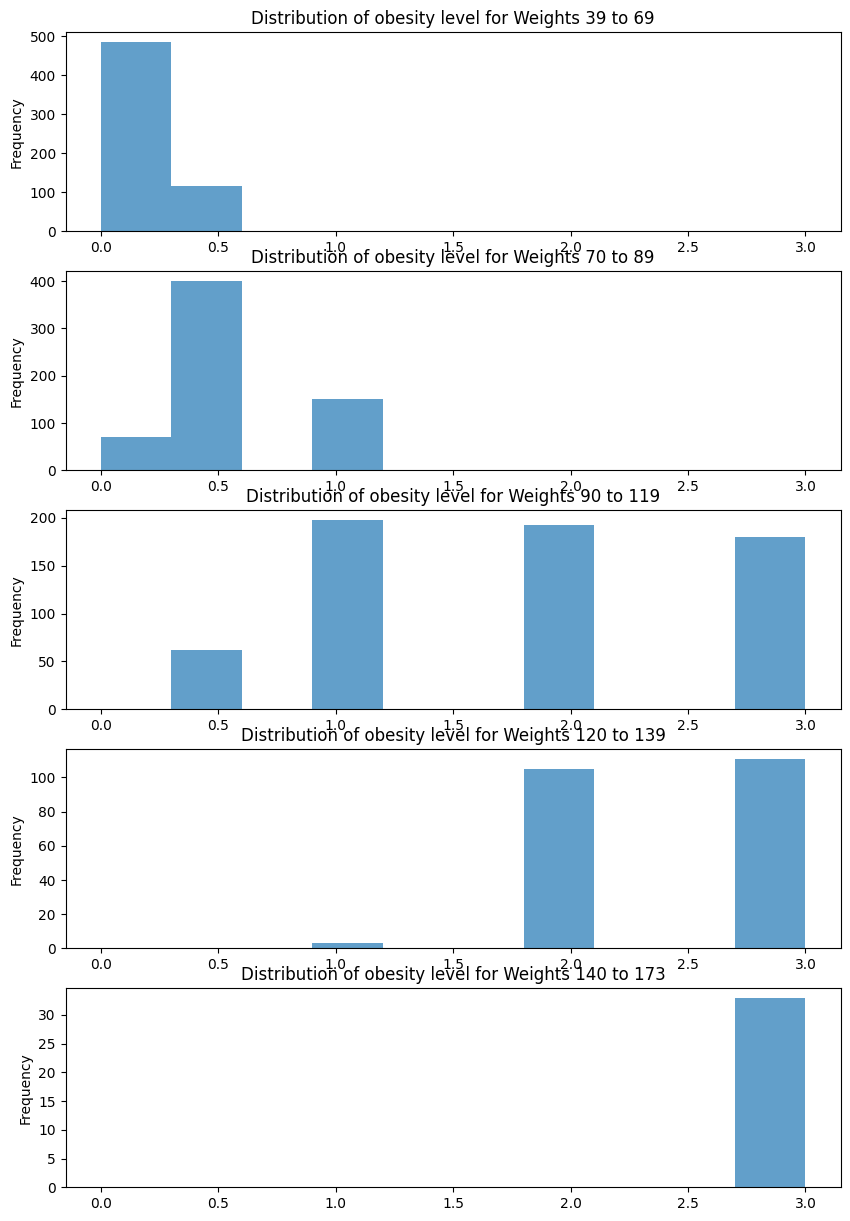

In [51]:
min = np.min(df["NObeyesdad"])
max = np.max(df["NObeyesdad"])

fig, axs = plt.subplots(5, figsize=(10, 15))

for i in range(5):
    axs[i].hist(weights_dfs[i]["NObeyesdad"], range=(min, max), alpha=0.7, label=labels[i])
    axs[i].set(title=f"Distribution of obesity level for {labels[i]}", ylabel="Frequency")

plt.show()

In [52]:
fam_his = df.groupby(["family_history_with_overweight"])
yes_df = fam_his.get_group(1)
no_df = fam_his.get_group(0)

len_y = len(yes_df)
len_n = len(no_df)

print("Number of yes family history with overweight: " + str(len_y))
print("Number of no family history with overweight: " + str(len_n))

Number of yes family history with overweight: 1726
Number of no family history with overweight: 385


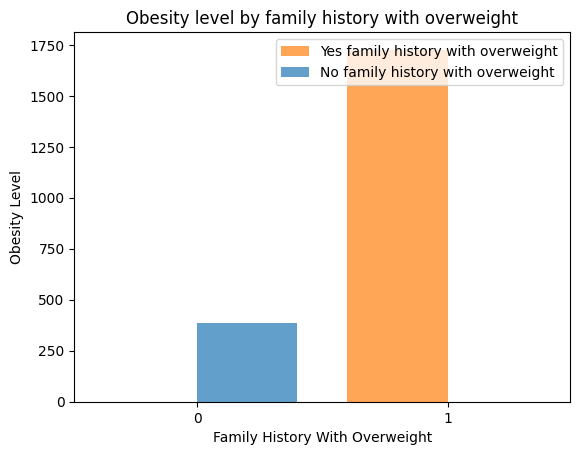

In [53]:
num_y = np.sum(yes_df["family_history_with_overweight"])
num_n = np.sum(no_df["family_history_with_overweight"])

fig, ax = plt.subplots(1)

x_axis = np.arange(2)

ax.bar(x_axis - 0.2, [len_y - num_y, num_y], width=0.4, color="tab:orange", alpha=0.7, label="Yes family history with overweight")
ax.bar(x_axis + 0.2, [len_n - num_n, num_n], width=0.4, color="tab:blue", alpha=0.7, label="No family history with overweight")

ax.set(title="Obesity level by family history with overweight", xlabel="Family History With Overweight", ylabel="Obesity Level")

plt.xticks(x_axis)
plt.legend()
plt.show()

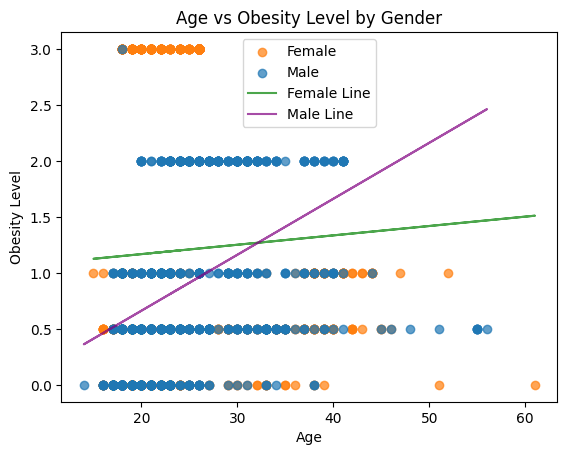

For women, obesity level increases by 0.008 per year on average
For men, obesity level increases by 0.050 per year on average


In [55]:
fig, ax = plt.subplots(1)

genders = df.groupby(["Gender"])
female_df = genders.get_group(0)
male_df = genders.get_group(1)

x1, y1 = female_df["Age"], female_df["NObeyesdad"]
x2, y2 = male_df["Age"], male_df["NObeyesdad"]

ax.scatter(x1, y1, color="tab:orange", alpha=0.7, label="Female")
ax.scatter(x2, y2, color="tab:blue", alpha=0.7, label="Male")
ax.set(title="Age vs Obesity Level by Gender", xlabel="Age", ylabel="Obesity Level")

m1, b1 = np.polyfit(x1, y1, 1)
ax.plot(x1, m1*x1+b1, color="green", alpha=0.7, label="Female Line")

m2, b2 = np.polyfit(x2, y2, 1)
ax.plot(x2, m2*x2+b2, color="purple", alpha=0.7, label="Male Line")

plt.legend()
plt.show()

print(f"For women, obesity level increases by {abs(m1):.3f} per year on average")
print(f"For men, obesity level increases by {abs(m2):.3f} per year on average")

In [56]:
female_r = np.corrcoef(x1, y1)[0, 1]
male_r = np.corrcoef(x2, y2)[0, 1]
print(f"Pearson (r) coef for female dataset: {female_r}")
print(f"Pearson (r) coef for male dataset: {male_r}")

Pearson (r) coef for female dataset: 0.042916420545538826
Pearson (r) coef for male dataset: 0.41409837411683886
